<a href="https://colab.research.google.com/github/ertgrulyksk/TESLA_Stock_Price_Forecast_with_Deep_Learning_LSTM/blob/main/TESLA_Stock_Price_Forecast_with_Deep_Learning_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import datetime as dt
import numpy as np
import urllib
import pandas as pd
import seaborn as sns
import random ,os ,glob
import matplotlib.pyplot as plt
import cv2
from imutils import paths
import itertools
from sklearn.utils import shuffle
from urllib.request import urlopen
import warnings
from sklearn.metrics import confusion_matrix,classification_report
import tensorflow as tf
from sklearn.metrics import mean_squared_error

from tensorflow.keras.models import Sequential
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.layers import Conv2D, Flatten, MaxPooling2D, Dense,Dropout,SpatialDropout2D,SimpleRNN,LSTM


In [2]:
warnings.filterwarnings('ignore')
import os 
os.environ["TF_CPP_MIN_LOG_LEVEL"]='3'
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

In [4]:
df=pd.read_csv("TSLA.csv")

In [5]:
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2010-06-29,19.000000,25.00,17.540001,23.889999,23.889999,18766300
1,2010-06-30,25.790001,30.42,23.299999,23.830000,23.830000,17187100
2,2010-07-01,25.000000,25.92,20.270000,21.959999,21.959999,8218800
3,2010-07-02,23.000000,23.10,18.709999,19.200001,19.200001,5139800
4,2010-07-06,20.000000,20.00,15.830000,16.110001,16.110001,6866900


In [6]:
def check_df(dataframe,head=5):
  print(dataframe.shape)
  print(dataframe.dtypes)
  print(dataframe.head(head))
  print(dataframe.tail(head))
  print(dataframe.isnull().sum())
  print(dataframe.quantile([0,0.05,0.50,0.95,0.99,1]).T)

In [7]:
check_df(df)

(2416, 7)
Date          object
Open         float64
High         float64
Low          float64
Close        float64
Adj Close    float64
Volume         int64
dtype: object
         Date       Open   High        Low      Close  Adj Close    Volume
0  2010-06-29  19.000000  25.00  17.540001  23.889999  23.889999  18766300
1  2010-06-30  25.790001  30.42  23.299999  23.830000  23.830000  17187100
2  2010-07-01  25.000000  25.92  20.270000  21.959999  21.959999   8218800
3  2010-07-02  23.000000  23.10  18.709999  19.200001  19.200001   5139800
4  2010-07-06  20.000000  20.00  15.830000  16.110001  16.110001   6866900
            Date        Open        High         Low       Close   Adj Close  \
2411  2020-01-28  568.489990  576.809998  558.080017  566.900024  566.900024   
2412  2020-01-29  575.690002  589.799988  567.429993  580.989990  580.989990   
2413  2020-01-30  632.419983  650.880005  618.000000  640.809998  640.809998   
2414  2020-01-31  640.000000  653.000000  632.520020  650.5

In [8]:
df["Date"]=pd.to_datetime(df["Date"])

In [9]:
tesla_df=df[["Date","Close"]]

In [10]:
tesla_df.head()

,Date,Close
0,2010-06-29,23.889999
1,2010-06-30,23.830000
2,2010-07-01,21.959999
3,2010-07-02,19.200001
4,2010-07-06,16.110001


In [11]:
print("Min Tarih:",tesla_df["Date"].min())
print("Max Tarih:",tesla_df["Date"].max())

Min Tarih: 2010-06-29 00:00:00
Max Tarih: 2020-02-03 00:00:00


In [12]:
tesla_df.index=tesla_df["Date"]

In [13]:
tesla_df.drop("Date",axis=1,inplace=True)

In [14]:
tesla_df

,Close
Date,
2010-06-29,23.889999
2010-06-30,23.830000
2010-07-01,21.959999
2010-07-02,19.200001
2010-07-06,16.110001
...,...
2020-01-28,566.900024
2020-01-29,580.989990
2020-01-30,640.809998


In [15]:
result_df=tesla_df.copy()

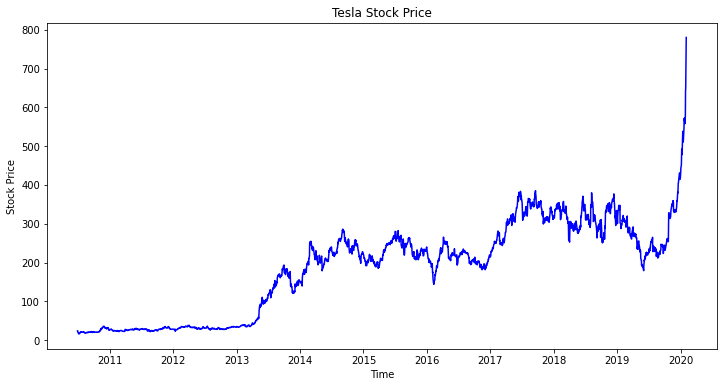

In [16]:
plt.figure(figsize=(12,6))
plt.plot(tesla_df["Close"],color="blue")
plt.ylabel("Stock Price")
plt.title("Tesla Stock Price")
plt.xlabel("Time")
plt.show()

In [17]:
tesla_df=tesla_df.values

In [18]:
tesla_df[0:5]

array([[23.889999],
       [23.83    ],
       [21.959999],
       [19.200001],
       [16.110001]])

In [19]:
tesla_df=tesla_df.astype("float32")

In [20]:
def split_data(dataframe,test_size):
  pos=int(round(len(dataframe)*(1-test_size)))
  train=dataframe[:pos]
  test=dataframe[pos:]
  return train,test,pos

In [21]:
train,test,pos=split_data(tesla_df,0.20)

In [22]:
print(train.shape,test.shape)

(1933, 1) (483, 1)


In [23]:
scaler_train=MinMaxScaler(feature_range=(0,1))
train=scaler_train.fit_transform(train)
scaler_test=MinMaxScaler(feature_range=(0,1))
test=scaler_test.fit_transform(test)

In [24]:
train[0:5]

array([[0.02191224],
       [0.02174973],
       [0.01668472],
       [0.0092091 ],
       [0.00083966]], dtype=float32)

In [25]:
test[0:5]

array([[0.25685903],
       [0.24829045],
       [0.25511202],
       [0.24978784],
       [0.2465767 ]], dtype=float32)

In [26]:
def create_features(data,lookback):
  X,Y=[],[]
  for i in range(lookback,len(data)):
    X.append(data[i-lookback:i,0])
    Y.append(data[i,0])

  return np.array(X), np.array(Y)

In [27]:
lookback=20

In [28]:
X_train,y_train=create_features(train,lookback)
X_test,y_test=create_features(test,lookback)
print(X_train.shape,y_train.shape,X_test.shape,y_test.shape)

(1913, 20) (1913,) (463, 20) (463,)


In [29]:
X_train[0:5]

array([[0.02191224, 0.02174973, 0.01668472, 0.0092091 , 0.00083966,
        0.        , 0.00449621, 0.00433369, 0.0033857 , 0.00633803,
        0.01094258, 0.011078  , 0.01310942, 0.0165493 , 0.01218851,
        0.01197183, 0.01408451, 0.01486999, 0.01394908, 0.01286566],
       [0.02174973, 0.01668472, 0.0092091 , 0.00083966, 0.        ,
        0.00449621, 0.00433369, 0.0033857 , 0.00633803, 0.01094258,
        0.011078  , 0.01310942, 0.0165493 , 0.01218851, 0.01197183,
        0.01408451, 0.01486999, 0.01394908, 0.01286566, 0.01332611],
       [0.01668472, 0.0092091 , 0.00083966, 0.        , 0.00449621,
        0.00433369, 0.0033857 , 0.00633803, 0.01094258, 0.011078  ,
        0.01310942, 0.0165493 , 0.01218851, 0.01197183, 0.01408451,
        0.01486999, 0.01394908, 0.01286566, 0.01332611, 0.01232395],
       [0.0092091 , 0.00083966, 0.        , 0.00449621, 0.00433369,
        0.0033857 , 0.00633803, 0.01094258, 0.011078  , 0.01310942,
        0.0165493 , 0.01218851, 0.01197183, 0

In [30]:
y_train[0:5]

array([0.01332611, 0.01232395, 0.01121344, 0.01386782, 0.01665764],
      dtype=float32)

In [31]:
X_train=np.reshape(X_train,(X_train.shape[0],1,X_train.shape[1]))
X_test=np.reshape(X_test,(X_test.shape[0],1,X_test.shape[1]))
y_train=y_train.reshape(-1,1)
y_test=y_test.reshape(-1,1)

In [32]:
print(X_train.shape,y_train.shape,X_test.shape,y_test.shape)

(1913, 1, 20) (1913, 1) (463, 1, 20) (463, 1)


In [33]:
model = Sequential()
model.add(LSTM(units=50,activation='relu', 
                    input_shape=(X_train.shape[1],lookback)))
model.add(Dropout(0.20))
model.add(Dense(1))

In [34]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 50)                14200     
                                                                 
 dropout (Dropout)           (None, 50)                0         
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 14,251
Trainable params: 14,251
Non-trainable params: 0
_________________________________________________________________


In [35]:
model.compile(optimizer = 'adam', loss = 'mean_squared_error')

In [36]:
callbacks=[EarlyStopping(monitor='val_loss',patience=3,verbose=1, mode='min'),
        ModelCheckpoint(filepath='mymodel.h5',monitor='val_loss',mode='min',save_best_only=True,save_weights_only=False,verbose=1)]

In [37]:
history=model.fit(x=X_train,y=y_train, epochs=100, batch_size=20,callbacks=callbacks,validation_data=(X_test,y_test),shuffle=False)

Epoch 1/100
77/96 [=======================>......] - ETA: 0s - loss: 0.0069
Epoch 1: val_loss improved from inf to 0.00437, saving model to mymodel.h5
96/96 [==============================] - 2s 5ms/step - loss: 0.0083 - val_loss: 0.0044
Epoch 2/100
85/96 [=========================>....] - ETA: 0s - loss: 0.0056
Epoch 2: val_loss improved from 0.00437 to 0.00340, saving model to mymodel.h5
96/96 [==============================] - 0s 3ms/step - loss: 0.0067 - val_loss: 0.0034
Epoch 3/100
94/96 [============================>.] - ETA: 0s - loss: 0.0052
Epoch 3: val_loss improved from 0.00340 to 0.00289, saving model to mymodel.h5
96/96 [==============================] - 0s 3ms/step - loss: 0.0053 - val_loss: 0.0029
Epoch 4/100
73/96 [=====================>........] - ETA: 0s - loss: 0.0029
Epoch 4: val_loss did not improve from 0.00289
96/96 [==============================] - 0s 3ms/step - loss: 0.0046 - val_loss: 0.0033
Epoch 5/100
88/96 [==========================>...] - ETA: 0s - loss:

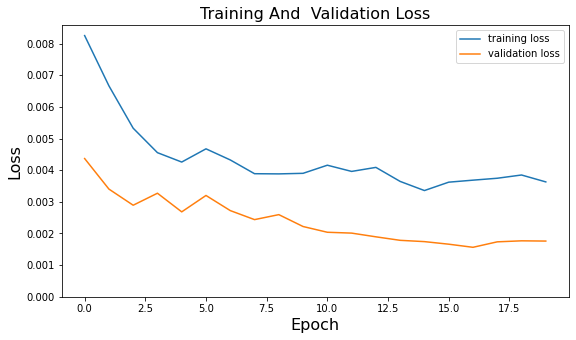

In [38]:
plt.figure(figsize=(20,5))
plt.subplot(1,2,2)
plt.plot(history.history["loss"],label="training loss")
plt.plot(history.history["val_loss"],label="validation loss")
plt.legend(loc="upper right")
plt.xlabel("Epoch", fontsize=16)
plt.ylabel("Loss",fontsize=16)
plt.ylim([0,max(plt.ylim())])
plt.title("Training And  Validation Loss",fontsize=16)
plt.show()

In [41]:
loss=model.evaluate(X_test,y_test,batch_size=20)

24/24 [==============================] - 0s 1ms/step - loss: 0.0018


In [42]:
print(100.0*loss)

0.17604886088520288


In [43]:
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)

15/15 [==============================] - 0s 2ms/step


In [44]:
train_predict=scaler_train.inverse_transform(train_predict)
test_predict=scaler_test.inverse_transform(test_predict)

In [45]:
y_train=scaler_train.inverse_transform(y_train)
y_test=scaler_test.inverse_transform(y_test)

In [46]:
train_rmse=np.sqrt(mean_squared_error(y_train,train_predict))
test_rmse=np.sqrt(mean_squared_error(y_test,test_predict))

In [47]:
print(train_rmse)

11.239913


In [48]:
print(test_rmse)

25.218126


In [49]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Open,2416.0,1.862711e+02,1.187402e+02,16.139999,3.434250e+01,2.130350e+02,2.664500e+02,6.736900e+02
High,2416.0,1.895782e+02,1.208923e+02,16.629999,3.489750e+01,2.167450e+02,2.709275e+02,7.861400e+02
Low,2416.0,1.829166e+02,1.168576e+02,14.980000,3.358750e+01,2.088700e+02,2.621025e+02,6.735200e+02
Close,2416.0,1.864037e+02,1.191360e+02,15.800000,3.440000e+01,2.129600e+02,2.667750e+02,7.800000e+02
Adj Close,2416.0,1.864037e+02,1.191360e+02,15.800000,3.440000e+01,2.129600e+02,2.667750e+02,7.800000e+02
Volume,2416.0,5.572722e+06,4.987809e+06,118500.000000,1.899275e+06,4.578400e+06,7.361150e+06,4.706500e+07


In [50]:
train_prediction_df=result_df[lookback:pos]
train_prediction_df["Predicted"]=train_predict
train_prediction_df.head()

,Close,Predicted
Date,,
2010-07-28,20.719999,36.869854
2010-07-29,20.350000,36.889774
2010-07-30,19.940001,36.951679
2010-08-02,20.920000,36.931065
2010-08-03,21.950001,36.895584


In [51]:
test_prediction_df= result_df[pos+lookback:]
test_prediction_df["Predicted"]=test_predict
test_prediction_df.head()

,Close,Predicted
Date,,
2018-04-03,267.529999,304.039825
2018-04-04,286.940002,301.402954
2018-04-05,305.720001,302.248474
2018-04-06,299.299988,306.463135
2018-04-09,289.660004,307.626526


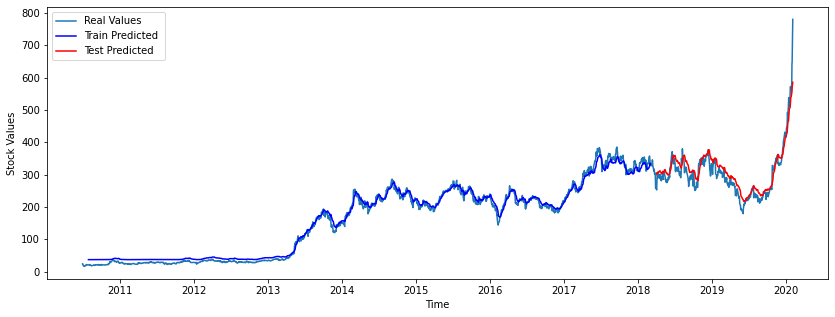

In [52]:
plt.figure(figsize=(14,5))
plt.plot(result_df,label="Real Values")
plt.plot(train_prediction_df["Predicted"],color="blue",label="Train Predicted ")
plt.plot(test_prediction_df["Predicted"],color="red",label="Test Predicted ")
plt.xlabel("Time")
plt.ylabel("Stock Values")
plt.legend()
plt.show()